In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr  7 21:38:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   1599MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

# Data Manipulation Only Detail Reduction + Unconstrained Models


We will manipulate data, then do density modelling on these modified points.

## Part 1 : Using PCA 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from sklearn.decomposition import PCA
from numpy import linalg as LA


In [ ]:
# params
n_batch = 512
image_size = (28, 28, 1)
n_train = int(60000 / n_batch)
n_test = int(10000 / n_batch)
N_Z = 28
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images_copy=train_images.copy()
X_train = train_images.reshape(60000, 28 * 28)
X_test = test_images.reshape(10000, 28 * 28)

In [ ]:
#PCA reduction
pca = PCA(n_components=28**2)
pca = pca.fit(X_train)
X_reduced = pca.transform(X_train)
Xtest_red = pca.transform(X_test)
# reconstruct data from compressed data
pca = PCA(n_components=X_reduced.shape[1])
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
Xtest_rec = pca.inverse_transform(Xtest_red)

non-compressed image


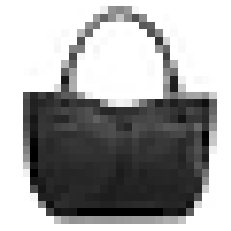

In [ ]:
print("non-compressed image")
plt.imshow(X_train[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

% variance compressed image


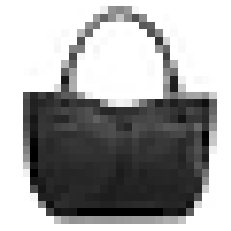

In [ ]:
print("% variance compressed image")
plt.imshow(X_recovered[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


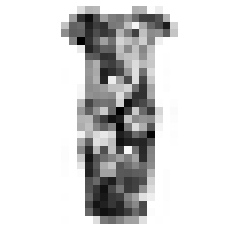

In [ ]:
print("95% variance compressed image")
plt.imshow(Xtest_rec[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


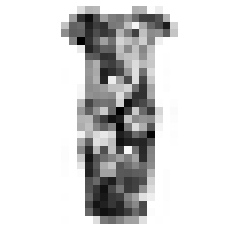

In [ ]:
print("95% variance compressed image")
plt.imshow(X_test[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
test_images=Xtest_rec
train_images=X_recovered

NameError: ignored

In [ ]:
# split dataset
train_image_gensized= train_images.reshape(train_images.shape[0],28,28)
train_images = train_images.reshape(train_images.shape[0], *image_size).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], *image_size).astype("float32") / 255.0

# batching datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(n_batch)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(n_batch)
)


In [ ]:
from skimage.metrics import structural_similarity as ssim
def compute_ssim_sets(ogdata, mod_data):
    ssim_data=0
    for idx in range(len(ogdata)):
        ssim_data+=ssim(ogdata[idx], mod_data[idx],
                  data_range= mod_data[idx].max()-  mod_data[idx].min())
    ssim_data=ssim_data/len(ogdata)
    return ssim_data

def compute_pts(original, generated):
    ssim_pt=ssim(original,generated,
                  data_range= generated.max()-  generated.min())
    return ssim_pt
compute_ssim_sets(train_images_copy, train_image_gensized)

1.0

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)
        self.count = 0

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """passes through the network and computes loss"""
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """passes through the network and computes loss"""
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )

        if self.count%1==0:
          self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables))
        else :
          pass

        self.count+=1
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels"""
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


In [ ]:
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=image_size),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [ ]:
def build_model(generator,discriminator,N_Z=28):
    # optimizers
    gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
    # model
    model = GAN(
        gen = generator,
        disc = discriminator,
        gen_optimizer = gen_optimizer,
        disc_optimizer = disc_optimizer,
        n_Z = N_Z)

    return model

# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2,N_Z=28):
    samples = model.generate(tf.random.normal(shape=(n_batch, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()
    return samples
    
model=build_model(generator, discriminator)

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 0 | disc_loss: 1.7637605667114258 | gen_loss: 0.4523398280143738


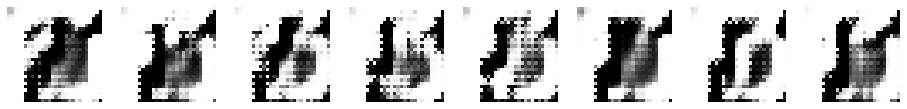

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1 | disc_loss: 0.6139249205589294 | gen_loss: 1.6708484888076782


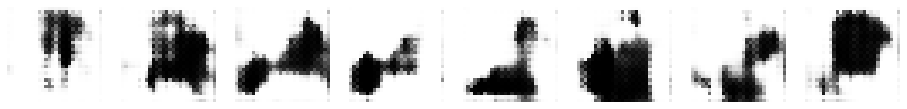

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2 | disc_loss: 1.0578655004501343 | gen_loss: 2.6531388759613037


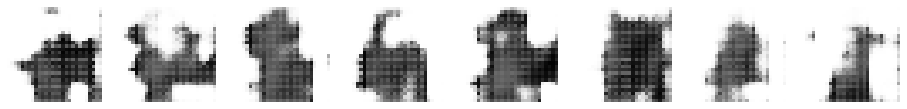

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3 | disc_loss: 0.7197381854057312 | gen_loss: 1.0684890747070312


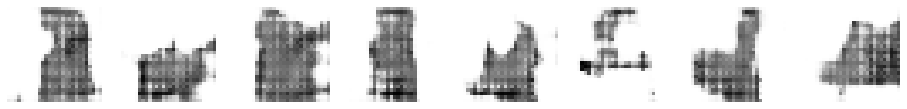

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4 | disc_loss: 1.7990044355392456 | gen_loss: 0.3510444462299347


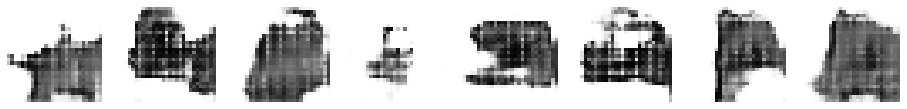

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5 | disc_loss: 0.8426946401596069 | gen_loss: 2.2966761589050293


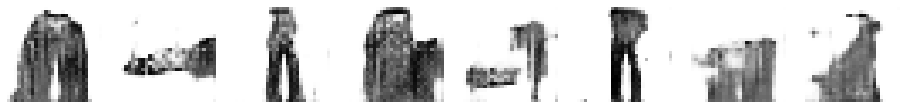

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6 | disc_loss: 0.8030498623847961 | gen_loss: 1.4730747938156128


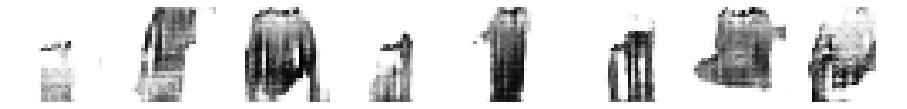

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7 | disc_loss: 1.1790088415145874 | gen_loss: 2.4193735122680664


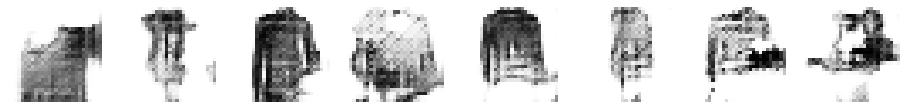

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8 | disc_loss: 0.9199509024620056 | gen_loss: 2.1507229804992676


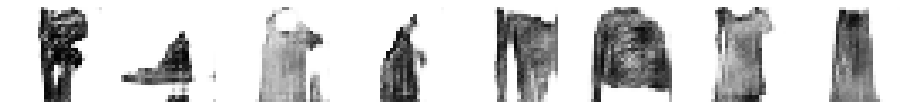

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 9 | disc_loss: 0.9507244229316711 | gen_loss: 0.9239389300346375


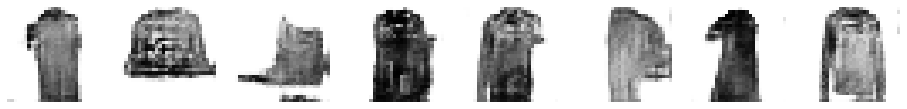

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10 | disc_loss: 0.7787750363349915 | gen_loss: 1.4129658937454224


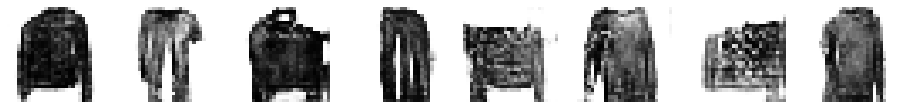

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 11 | disc_loss: 0.7860616445541382 | gen_loss: 1.33563232421875


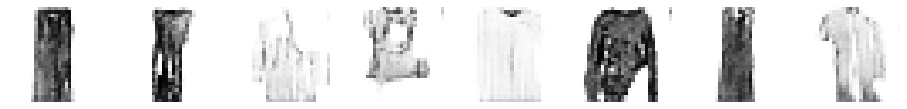

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12 | disc_loss: 0.7777215838432312 | gen_loss: 1.2831073999404907


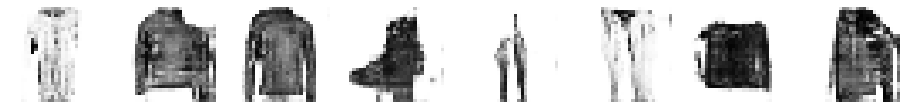

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 13 | disc_loss: 0.6930928826332092 | gen_loss: 1.4319530725479126


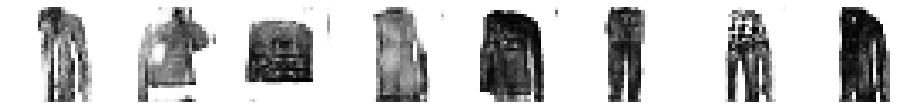

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 14 | disc_loss: 0.7476813793182373 | gen_loss: 1.9575870037078857


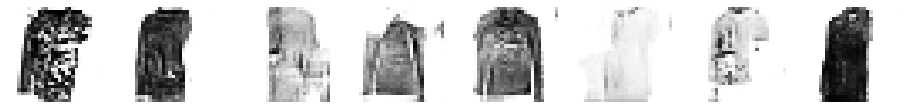

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 15 | disc_loss: 1.0777113437652588 | gen_loss: 2.607913017272949


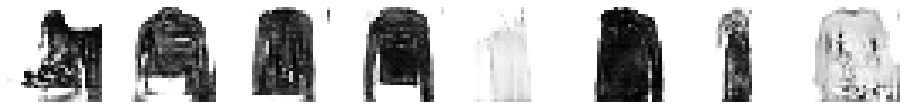

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 16 | disc_loss: 0.7151299118995667 | gen_loss: 2.265291213989258


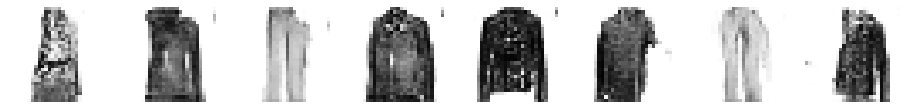

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 17 | disc_loss: 0.7521779537200928 | gen_loss: 1.9014983177185059


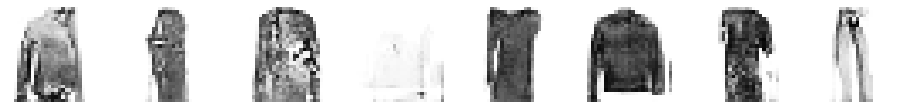

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 18 | disc_loss: 0.8041200637817383 | gen_loss: 1.0909112691879272


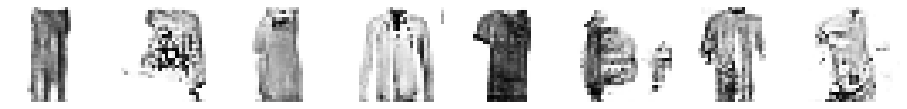

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 19 | disc_loss: 0.7172577381134033 | gen_loss: 1.4561092853546143


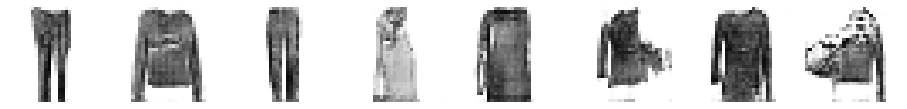

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 20 | disc_loss: 0.7368525266647339 | gen_loss: 1.3459233045578003


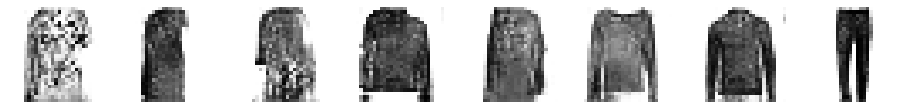

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 21 | disc_loss: 0.8471094369888306 | gen_loss: 2.6409358978271484


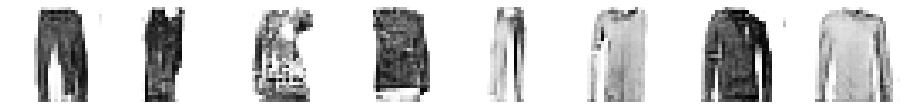

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 22 | disc_loss: 0.7310486435890198 | gen_loss: 1.5005910396575928


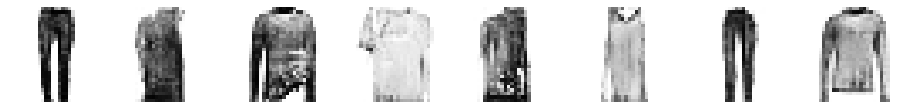

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 23 | disc_loss: 0.7168709635734558 | gen_loss: 1.7133709192276


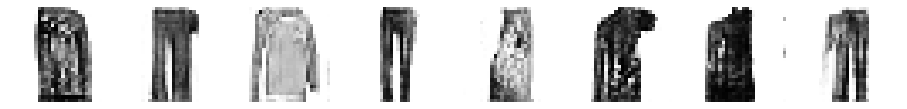

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 24 | disc_loss: 0.7239984273910522 | gen_loss: 2.159027576446533


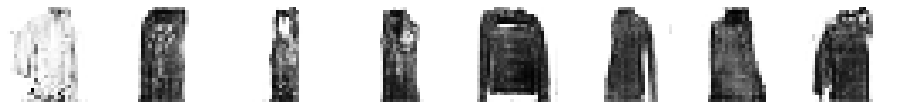

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 25 | disc_loss: 0.7381701469421387 | gen_loss: 1.5369521379470825


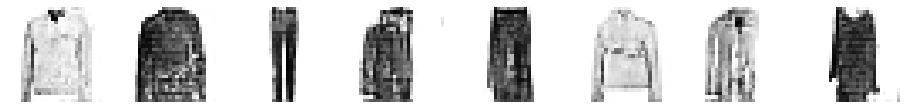

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 26 | disc_loss: 0.7224299311637878 | gen_loss: 1.5251390933990479


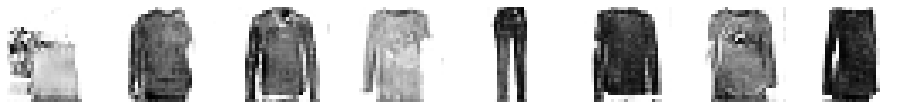

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 27 | disc_loss: 0.7507906556129456 | gen_loss: 1.7758111953735352


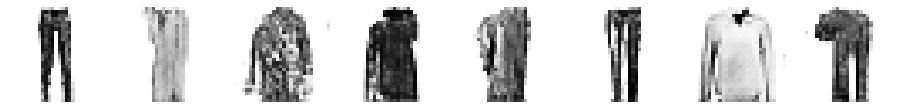

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 28 | disc_loss: 0.8262303471565247 | gen_loss: 1.577411413192749


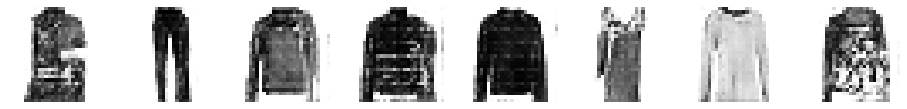

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 29 | disc_loss: 0.8668769001960754 | gen_loss: 1.185424566268921


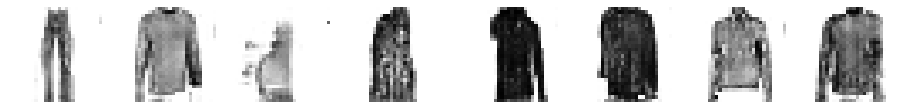

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 30 | disc_loss: 0.8256595134735107 | gen_loss: 1.58014714717865


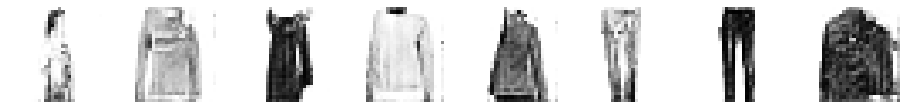

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 31 | disc_loss: 0.854316234588623 | gen_loss: 1.773826241493225


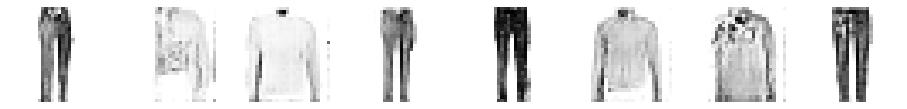

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 32 | disc_loss: 0.8525990843772888 | gen_loss: 1.3010094165802002


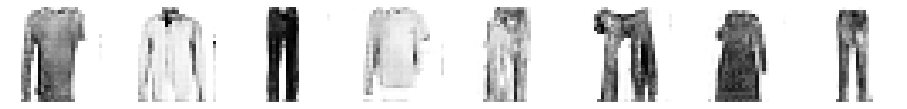

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 33 | disc_loss: 0.8867469429969788 | gen_loss: 1.4746577739715576


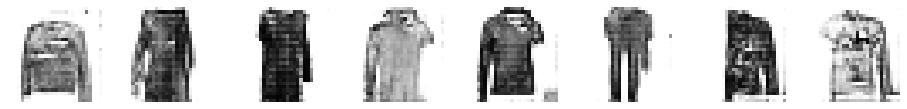

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 34 | disc_loss: 1.0105193853378296 | gen_loss: 1.8717892169952393


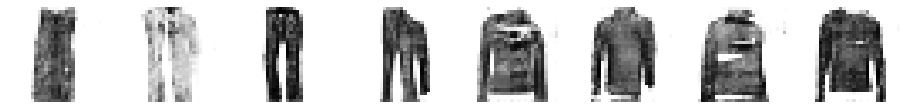

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 35 | disc_loss: 0.9266176819801331 | gen_loss: 1.3111425638198853


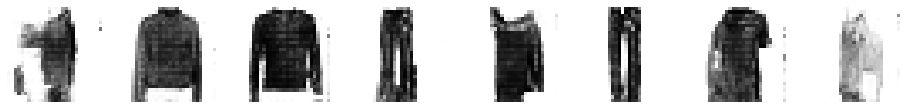

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 36 | disc_loss: 0.9396052360534668 | gen_loss: 1.2739356756210327


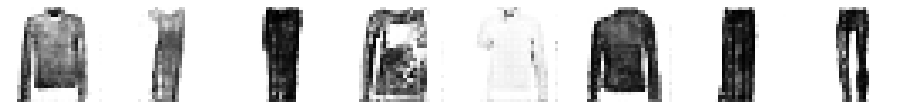

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 37 | disc_loss: 0.9573010802268982 | gen_loss: 1.4355510473251343


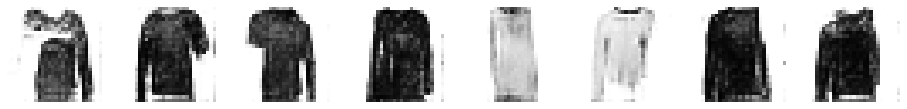

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 38 | disc_loss: 1.349098563194275 | gen_loss: 3.6288840770721436


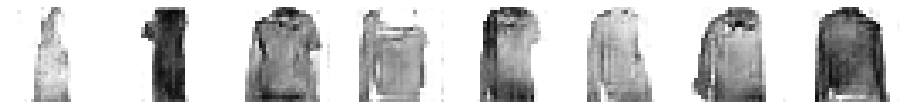

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 39 | disc_loss: 0.9109620451927185 | gen_loss: 1.393100380897522


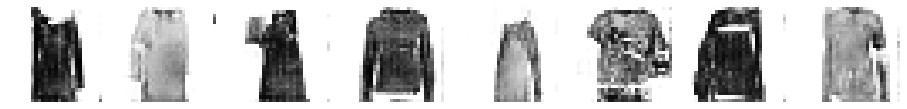

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 40 | disc_loss: 0.9167934060096741 | gen_loss: 1.3065701723098755


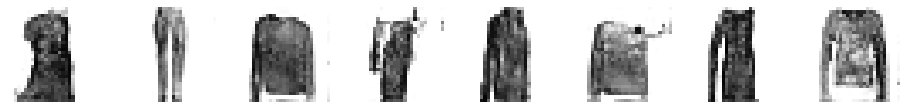

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 41 | disc_loss: 1.2476319074630737 | gen_loss: 0.6818593740463257


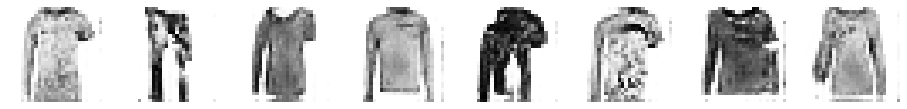

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 42 | disc_loss: 0.9386127591133118 | gen_loss: 1.405194640159607


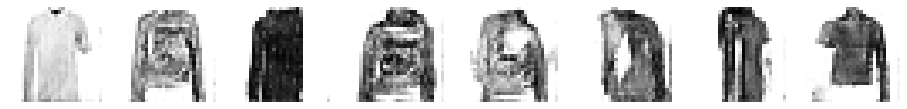

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 43 | disc_loss: 1.048280954360962 | gen_loss: 1.7883220911026


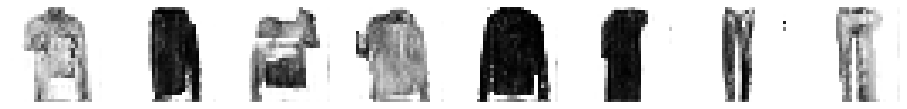

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 44 | disc_loss: 1.001462697982788 | gen_loss: 1.9486411809921265


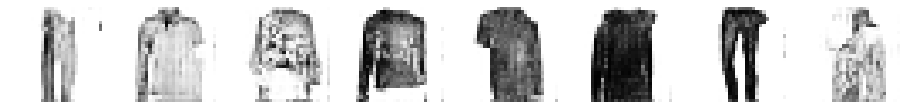

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 45 | disc_loss: 0.9660196900367737 | gen_loss: 1.3621900081634521


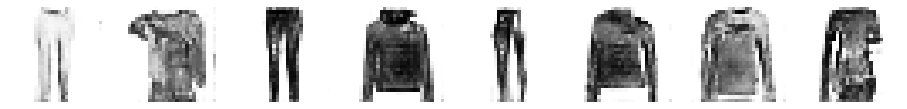

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 46 | disc_loss: 1.1039228439331055 | gen_loss: 0.973308265209198


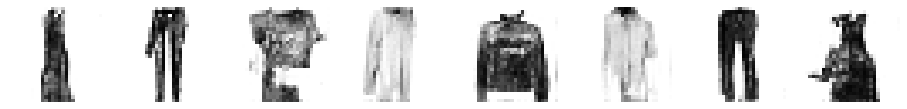

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 47 | disc_loss: 1.2948944568634033 | gen_loss: 1.030359148979187


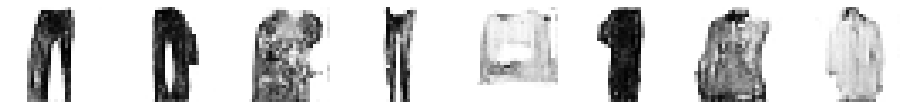

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 48 | disc_loss: 0.9621267914772034 | gen_loss: 1.2737714052200317


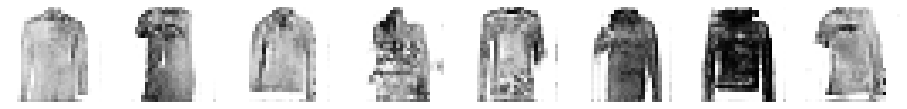

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 49 | disc_loss: 1.0023458003997803 | gen_loss: 1.2857961654663086


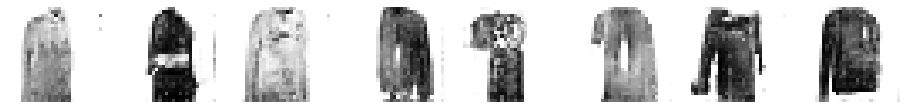

array([1.7637606 , 0.6139249 , 1.0578655 , 0.7197382 , 1.7990044 ,
       0.84269464, 0.80304986, 1.1790088 , 0.9199509 , 0.9507244 ,
       0.77877504, 0.78606164, 0.7777216 , 0.6930929 , 0.7476814 ,
       1.0777113 , 0.7151299 , 0.75217795, 0.80412006, 0.71725774,
       0.7368525 , 0.84710944, 0.73104864, 0.71687096, 0.7239984 ,
       0.73817015, 0.72242993, 0.75079066, 0.82623035, 0.8668769 ,
       0.8256595 , 0.85431623, 0.8525991 , 0.88674694, 1.0105194 ,
       0.9266177 , 0.93960524, 0.9573011 , 1.3490986 , 0.91096205,
       0.9167934 , 1.2476319 , 0.93861276, 1.048281  , 1.0014627 ,
       0.9660197 , 1.1039228 , 1.2948945 , 0.9621268 , 1.0023458 ],
      dtype=float32)

In [ ]:
# saving training stats
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
# training loop
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_train), train_dataset), total=n_train

    ): 

        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_test), test_dataset), total=n_test
    ):
        loss.append(model.compute_loss(test_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)

    #prints
    
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    #plt.plot(losses.disc_loss.values)
    #plt.plot(losses.gen_loss.values)
    #plt.show()
    plot_reconstruction(model)

    

losses.disc_loss.values   

In [ ]:
def method_score(data, samples,pts):
  errors=[]
  print(len(samples))
  for item in samples:
    random_indices= np.random.choice(len(data),pts)
    errors.append(max([compute_pts(x,item) for x in data[random_indices]]))
  return np.mean(errors)

In [ ]:
samples = model.generate(tf.random.normal(shape=(N_Z, N_Z)))
method_score(np.squeeze(train_images),np.squeeze(samples),10000)

28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


0.5807508918851687

## Part 2 : Using SVD





In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from sklearn.decomposition import TruncatedSVD

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
# params
n_batch = 128
image_size = (28, 28, 1)
n_train = int(60000 / n_batch)
n_test = int(10000 / n_batch)
N_Z = 28
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images_copy=train_images.copy()
X_train = train_images.reshape(60000, 28 * 28)
X_test = test_images.reshape(10000, 28 * 28)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
#PCA reduction
svd = TruncatedSVD(n_components=100)
svd = svd.fit(X_train)
X_reduced = svd.transform(X_train)
Xtest_red = svd.transform(X_test)


In [ ]:
# reconstruct data from compressed data
svd = TruncatedSVD(n_components=X_reduced.shape[1])
X_reduced = svd.fit_transform(X_train)
X_recovered = svd.inverse_transform(X_reduced)
Xtest_rec = svd.inverse_transform(Xtest_red)

non-compressed image


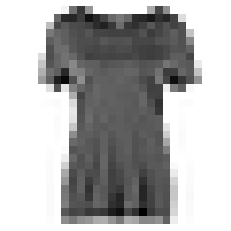

In [ ]:
print("non-compressed image")
plt.imshow(X_train[10].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


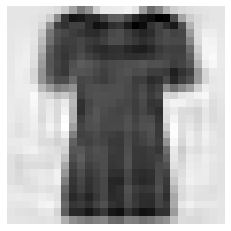

In [ ]:
print("95% variance compressed image")
plt.imshow(X_recovered[10].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
test_images=Xtest_rec
train_images=X_recovered


In [ ]:
# split dataset
train_image_gensized= train_images.reshape(train_images.shape[0],28,28)
train_images = train_images.reshape(train_images.shape[0], *image_size).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], *image_size).astype("float32") / 255.0

# batching datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(n_batch)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(n_batch)
)



In [ ]:
from skimage.metrics import structural_similarity as ssim
def compute_ssim_sets(ogdata, mod_data):
    ssim_data=0
    for idx in range(len(ogdata)):
        ssim_data+=ssim(ogdata[idx], mod_data[idx],
                  data_range= mod_data[idx].max()-  mod_data[idx].min())
    ssim_data=ssim_data/len(ogdata)
    return ssim_data

def compute_pts(original, generated):
    ssim_pt=ssim(original,generated,
                  data_range= generated.max()-  generated.min())
    return ssim_pt
compute_ssim_sets(train_images_copy, train_image_gensized)

0.7902244639228586

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)
        self.count = 0

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """passes through the network and computes loss"""
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """passes through the network and computes loss"""
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )

        if self.count%1==0:
          self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables))
        else :
          pass

        self.count+=1
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels"""
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


In [ ]:
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=image_size),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [ ]:
def build_model(generator,discriminator,N_Z=28):
    # optimizers
    gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
    # model
    model = GAN(
        gen = generator,
        disc = discriminator,
        gen_optimizer = gen_optimizer,
        disc_optimizer = disc_optimizer,
        n_Z = N_Z)

    return model

# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2,N_Z=28):
    samples = model.generate(tf.random.normal(shape=(n_batch, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()
    return samples
    
model=build_model(generator, discriminator)


  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch: 0 | disc_loss: 0.09885738790035248 | gen_loss: 2.363098382949829


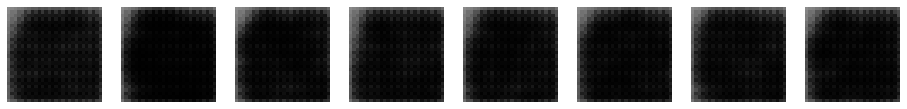

array([0.09885739], dtype=float32)

In [ ]:
# saving training stats
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
# training loop
n_epochs = 1
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_train), train_dataset), total=n_train

    ): 

        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_test), test_dataset), total=n_test
    ):
        loss.append(model.compute_loss(test_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)

    #prints
    
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    #plt.plot(losses.disc_loss.values)
    #plt.plot(losses.gen_loss.values)
    #plt.show()
    plot_reconstruction(model)



    

losses.disc_loss.values   

In [ ]:
model.layers[0].layers[-1].get_weights()

[array([[[[ 4.10172381e-02,  1.75510868e-02,  8.65120366e-02,
            1.30323663e-01,  1.63310468e-01, -9.00823474e-02,
           -4.54235822e-02, -1.36958331e-01,  9.12068114e-02,
            1.50426365e-02,  1.72683634e-02,  3.96442227e-03,
            1.51583135e-01,  8.73935223e-03,  2.63496302e-02,
           -1.16226293e-01,  1.62094105e-02,  5.72582670e-02,
           -7.36382790e-03,  4.24567051e-02, -3.48748080e-02,
           -2.66694627e-03, -4.44510579e-03,  2.36039888e-02,
            6.20353073e-02, -9.39085856e-02, -9.09538195e-02,
           -7.40920827e-02, -3.59529145e-02,  1.43886402e-01,
            3.73332351e-02, -6.22406192e-02]],
 
         [[-6.36487748e-05,  1.30616903e-01, -7.35657942e-03,
           -5.33678904e-02, -2.67827548e-02,  4.67839725e-02,
           -1.32582232e-01,  7.16707669e-03,  3.73891219e-02,
           -7.12088943e-02, -4.95137274e-02,  7.64309391e-02,
            1.19914986e-01, -7.64854774e-02, -2.36273669e-02,
           -6.3929304

In [ ]:
def method_score(data, samples,pts):
  errors=[]
  print(len(samples))
  for item in samples:
    random_indices= np.random.choice(len(data),pts)
    errors.append(max([compute_pts(x,item) for x in data[random_indices]]))
  return np.mean(errors)

In [ ]:
samples = model.generate(tf.random.normal(shape=(n_batch//10, N_Z)))
method_score(np.squeeze(train_images),np.squeeze(samples),500)

12


0.16688606220831403

# Part 3 : NMF (Skipped)

This method was too slow.

# Part 4 : Data Manipulation MethodM (Skipped)